# How to import Ansys meshes
This notebook demonstrates how to import simulation results from Ansys in pylife, e.g., to be used for a FKM nonlinear assessment. This notebook uses the `pymapdl` reader package, so no installation of Ansys is required.
You may need to install `pip install ansys-mapdl-reader` though.

Because working with large meshes can be time-consuming, we also show how a mesh dataset can be filtered.

In [1]:
# base packages
import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import timeit

# Ansys import
from ansys.mapdl import reader as pymapdl_reader

# import pylife.vmap
# pylife
from pylife.strength import failure_probability as fp

import pylife
import pylife.vmap
import pylife.mesh
import pylife.stress.equistress
import pylife.mesh.gradient

Read ANSYS file

In [2]:
filename = 'data/kt1.rst'
result = pymapdl_reader.read_binary(filename)
print(f"The mesh has {result.mesh.n_node} nodes.")

The mesh has 5234 nodes.


Process the mesh data and transform it into the pylife mesh format.

In [3]:
element_number_list = result.element_stress(0)

node_location = result.mesh.nodes
nodal_results = result.nodal_stress(0)
equivalent_results = result.principal_nodal_stress(0)

node_location_df = pd.DataFrame(node_location, columns=['x', 'y', 'z'])
node_number = pd.DataFrame(nodal_results[0], columns=['node_id'], dtype=int)
nodal_stress = pd.DataFrame(nodal_results[1], columns = ['S11', 'S22', 'S33', 'S12', 'S13', 'S23'])
nodal_equivalent_stress = pd.DataFrame(equivalent_results[1], columns = ['S1', 'S2', 'S3', 'S_Int', 'mises'])

data = [node_number, node_location_df, nodal_stress, nodal_equivalent_stress]

mesh_data = pd.concat(data, axis=1)
mesh_data = mesh_data.set_index("node_id")

# create multi-index for FE mesh in pylife
tuples = [(elem[8], elem[10+i]) for elem in result.mesh.elem for i in range(len(elem)-10)]
index = pd.MultiIndex.from_tuples(tuples, 
                          names=["element_id", "node_id"])
# sort multi-index by element_id, but keep order of node-ids per element
index,_ = index.sortlevel(0, sort_remaining=False)   

# join mesh data with multi index
pylife_mesh = pd.DataFrame(index=index)
pylife_mesh = pylife_mesh.join(mesh_data, on="node_id")

Now, we have the mesh as a pandas DataFrame with multi-index:

In [4]:
pylife_mesh

x         y         z         S11        S22  \
element_id node_id                                                      
1          3       -57.366  2.413933 -3.741171  108.238853   6.379151   
           11      -57.366  0.854813 -3.506357  108.498573  10.216134   
           10      -57.366  1.983905 -1.949832  104.231324   9.652120   
           9       -57.366  3.441688 -2.388185  108.020267   5.326337   
           834     -60.000  2.413933 -3.741171   80.812887  28.884796   
...                    ...       ...       ...         ...        ...   
1100       4139     60.000  0.342943  2.485073         NaN        NaN   
           4042     58.683  0.702076  1.650659         NaN        NaN   
           4078     58.683  1.691471  2.753514         NaN        NaN   
           4076     58.683 -0.016190  3.319486         NaN        NaN   
           4076     58.683 -0.016190  3.319486         NaN        NaN   

                          S33       S12       S13        S23          S1  \
element_id node_id                                                         
1          3         5.255035 -2.531445  1.917462   3.907116  108.446044   
           11        7.123171 -1.437574  1.154890   6.151290  108.889352   
           10        9.806512 -3.797827  1.273882   3.748143  104.527682   
           9         6.636424 -3.754937  2.236027   2.882552  108.234534   
           834      24.424774 -8.829359  3.307420  12.762588   84.702835   
...                       ...       ...       ...        ...         ...   
1100       4139           NaN       NaN       NaN        NaN         NaN   
           4042           NaN       NaN       NaN        NaN         NaN   
           4078           NaN       NaN       NaN        NaN         NaN   
           4076           NaN       NaN       NaN        NaN         NaN   
           4076           NaN       NaN       NaN        NaN         NaN   

                           S2         S3       S_Int       mises  
element_id node_id                                                
1          3         7.814291   3.612704  104.833340  102.796965  
           11       10.596720   6.351806  102.537546  100.482359  
           10       11.005382   8.156892   96.370791   94.978587  
           9         8.311350   3.437143  104.797391  102.447288  
           834      30.603213  18.816408   65.886427   60.855235  
...                       ...        ...         ...         ...  
1100       4139           NaN        NaN         NaN         NaN  
           4042           NaN        NaN         NaN         NaN  
           4078           NaN        NaN         NaN         NaN  
           4076           NaN        NaN         NaN         NaN  
           4076           NaN        NaN         NaN         NaN  

[22000 rows x 14 columns]

In [5]:
# Calculate the stress gradient
tstart = timeit.default_timer()
grad1 = pylife_mesh.gradient_3D.gradient_of('mises')
tend = timeit.default_timer()
print(f"duration calculate stress gradient: {tend-tstart:.1f} s")

grad1["abs_grad"] = np.linalg.norm(grad1, axis=1)
pylife_mesh = pylife_mesh.join(grad1, sort=False)

duration calculate stress gradient: 7.3 s


## Plot the mesh
Plot the absolute stress gradient G.

C:\Users\mbe7rng\AppData\Local\Temp\ipykernel_15156\12501235.py:6: UserWarning: VTK 9 no longer accepts an offset array
  grid = pv.UnstructuredGrid(*pylife_mesh.mesh.vtk_data())
C:\Users\mbe7rng\AppData\Roaming\Python\Python39\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


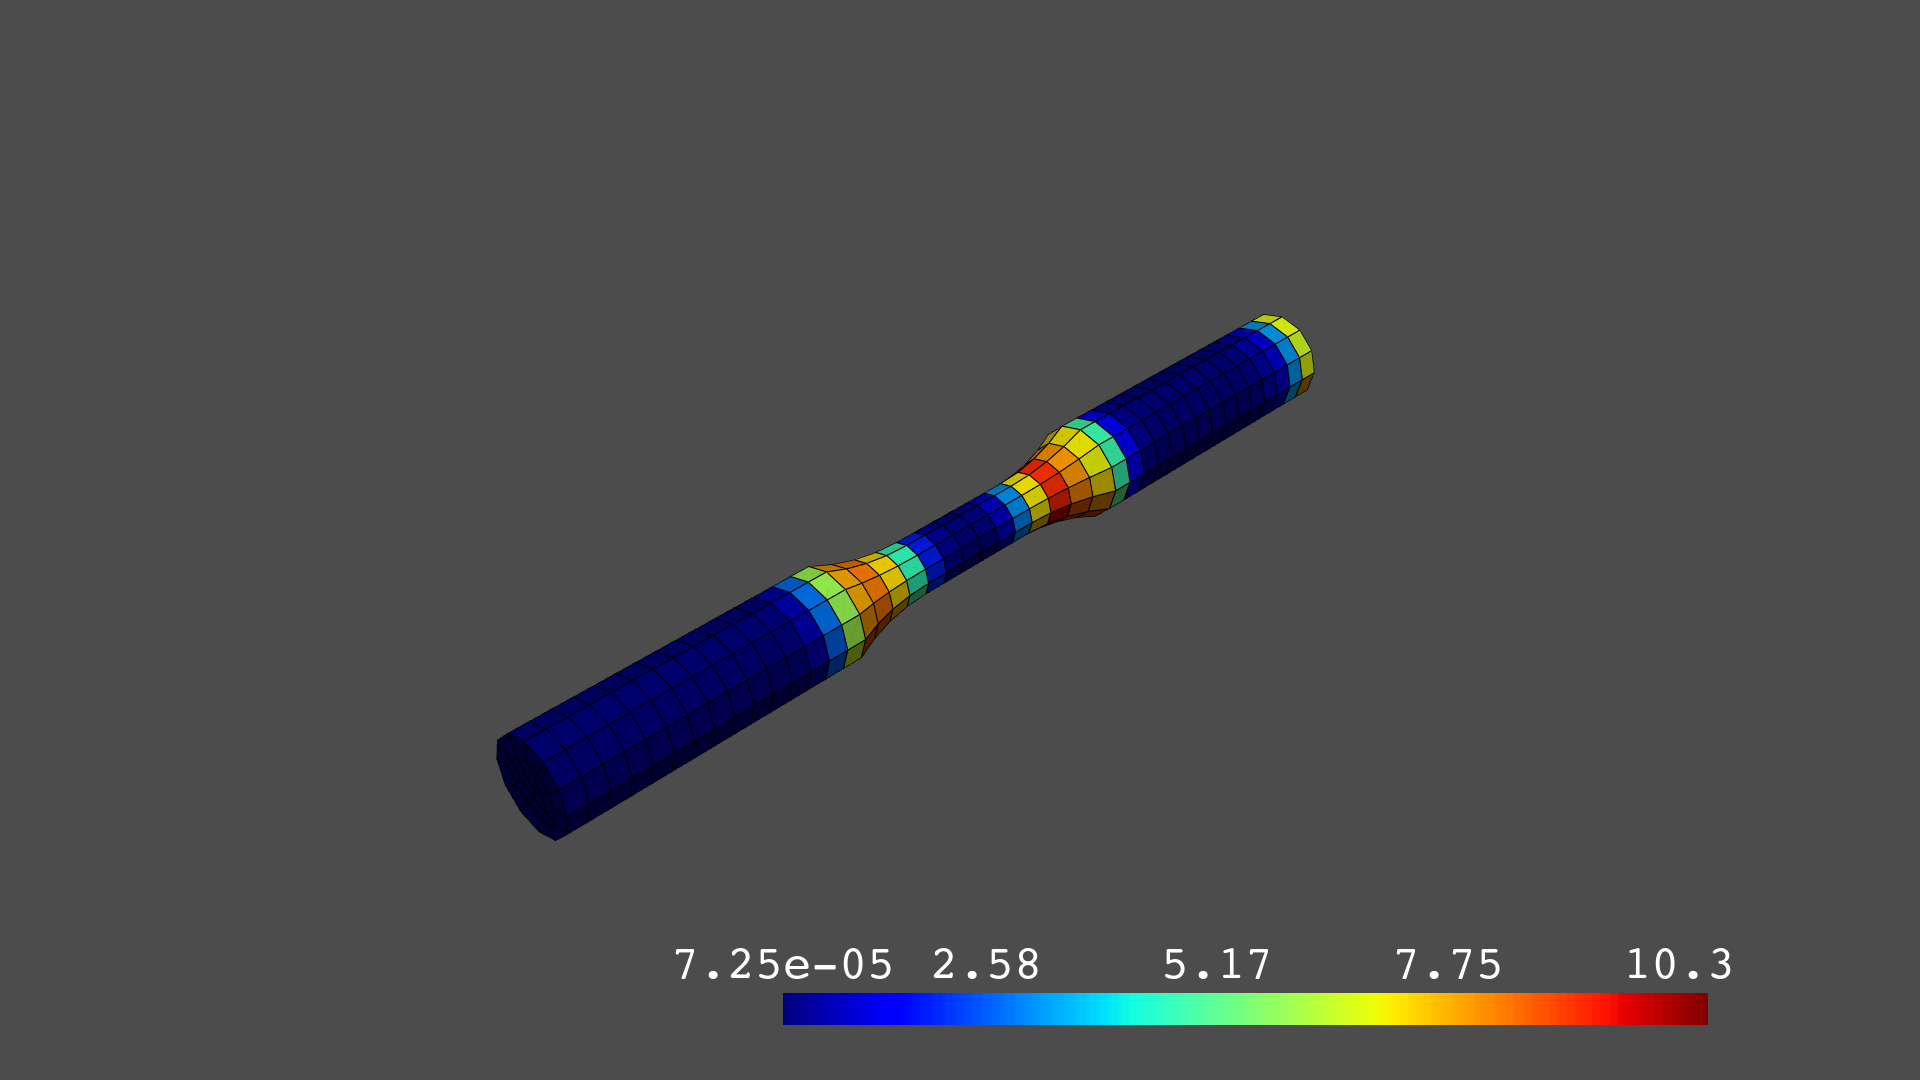

In [6]:
import pyvista as pv

# import profile
mpl.style.use('bmh')

grid = pv.UnstructuredGrid(*pylife_mesh.mesh.vtk_data())
plotter = pv.Plotter(window_size=[1920, 1080])
plotter.add_mesh(grid, scalars=pylife_mesh.groupby('element_id')['abs_grad'].mean().to_numpy(),
                show_edges=True, cmap='jet')
plotter.add_scalar_bar()
plotter.show()
# =============================================================================

Plot the Mises stress.

C:\Users\mbe7rng\AppData\Local\Temp\ipykernel_15156\1318154742.py:1: UserWarning: VTK 9 no longer accepts an offset array
  grid = pv.UnstructuredGrid(*pylife_mesh.mesh.vtk_data())
C:\Users\mbe7rng\AppData\Roaming\Python\Python39\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


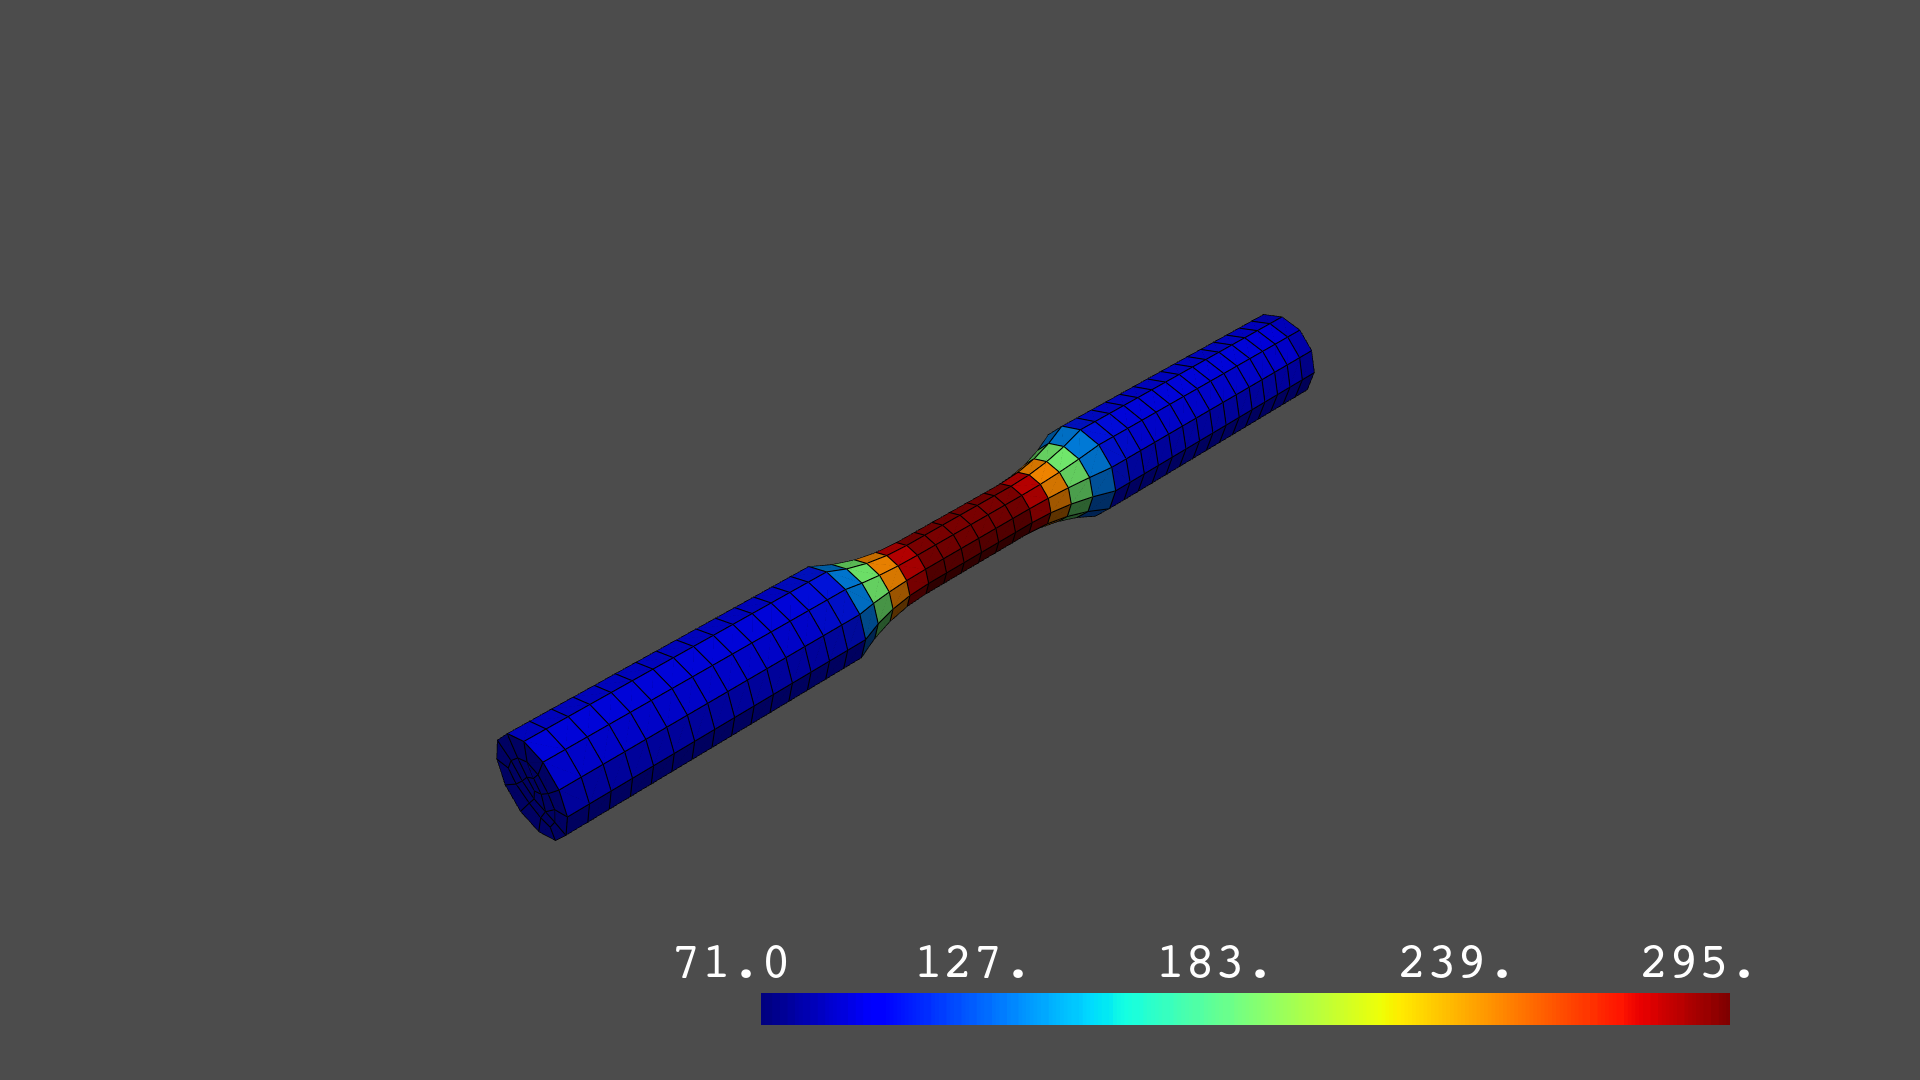

In [7]:
grid = pv.UnstructuredGrid(*pylife_mesh.mesh.vtk_data())
plotter = pv.Plotter(window_size=[1920, 1080])
plotter.add_mesh(grid, scalars=pylife_mesh.groupby('element_id')['mises'].mean().to_numpy(),
                show_edges=True, cmap='jet')
plotter.add_scalar_bar()
plotter.show()

## Select surface elements
Often, we want to only consider the finite elements that touch the surface of the 3D object, because the highest fatigue load is often located at the surface.
A heuristic is to count the number of adjacent elements for each node and filter the node set by this number. At the surface, less elements are next to each other than in the interior of the volume. The actual number depends on the used element types.

In [8]:
# compute number of elements that are adjacent for each node
pylife_mesh_temp = pylife_mesh.copy()
pylife_mesh_temp["element_id"] = pylife_mesh_temp.index.get_level_values("element_id")
pylife_mesh_temp = pylife_mesh_temp.droplevel("element_id")
n_elements_per_node = pylife_mesh_temp.groupby("node_id")["element_id"].nunique()


In [9]:
# How many elements max. should touch at a node to be considered a surface node?
n_elements = 2  # for a hexahedral mesh
#n_elements = 4  # for a tetrahedral mesh

# select nodes with less than a certain number of elements
surface_node_ids = n_elements_per_node[n_elements_per_node<=n_elements].index
surface_element_ids = pylife_mesh_temp.loc[surface_node_ids,"element_id"].unique()
surface_mesh = pylife_mesh[pylife_mesh.index.get_level_values("element_id").isin(surface_element_ids)]

n_elements_original = pylife_mesh.index.get_level_values("element_id").nunique()
print(f"select {len(surface_element_ids)} elements of {n_elements_original} "
      f"(= {100*len(surface_element_ids)/n_elements_original:.1f} %)")

select 554 elements of 1100 (= 50.4 %)


The resulting mesh at the surface has the following elements:

In [10]:
surface_mesh

x         y         z         S11        S22  \
element_id node_id                                                      
1          3       -57.366  2.413933 -3.741171  108.238853   6.379151   
           11      -57.366  0.854813 -3.506357  108.498573  10.216134   
           10      -57.366  1.983905 -1.949832  104.231324   9.652120   
           9       -57.366  3.441688 -2.388185  108.020267   5.326337   
           834     -60.000  2.413933 -3.741171   80.812887  28.884796   
...                    ...       ...       ...         ...        ...   
1100       4139     60.000  0.342943  2.485073         NaN        NaN   
           4042     58.683  0.702076  1.650659         NaN        NaN   
           4078     58.683  1.691471  2.753514         NaN        NaN   
           4076     58.683 -0.016190  3.319486         NaN        NaN   
           4076     58.683 -0.016190  3.319486         NaN        NaN   

                          S33       S12       S13        S23          S1  \
element_id node_id                                                         
1          3         5.255035 -2.531445  1.917462   3.907116  108.446044   
           11        7.123171 -1.437574  1.154890   6.151290  108.889352   
           10        9.806512 -3.797827  1.273882   3.748143  104.527682   
           9         6.636424 -3.754937  2.236027   2.882552  108.234534   
           834      24.424774 -8.829359  3.307420  12.762588   84.702835   
...                       ...       ...       ...        ...         ...   
1100       4139           NaN       NaN       NaN        NaN         NaN   
           4042           NaN       NaN       NaN        NaN         NaN   
           4078           NaN       NaN       NaN        NaN         NaN   
           4076           NaN       NaN       NaN        NaN         NaN   
           4076           NaN       NaN       NaN        NaN         NaN   

                           S2         S3       S_Int       mises  dmises_dx  \
element_id node_id                                                            
1          3         7.814291   3.612704  104.833340  102.796965  15.923208   
           11       10.596720   6.351806  102.537546  100.482359  17.981257   
           10       11.005382   8.156892   96.370791   94.978587  15.056013   
           9         8.311350   3.437143  104.797391  102.447288  16.663164   
           834      30.603213  18.816408   65.886427   60.855235  15.923208   
...                       ...        ...         ...         ...        ...   
1100       4139           NaN        NaN         NaN         NaN   0.000000   
           4042           NaN        NaN         NaN         NaN   0.000000   
           4078           NaN        NaN         NaN         NaN   0.000000   
           4076           NaN        NaN         NaN         NaN   0.000000   
           4076           NaN        NaN         NaN         NaN   0.000000   

                    dmises_dy  dmises_dz   abs_grad  
element_id node_id                                   
1          3         1.297227  -1.243848  16.024310  
           11        0.858257  -4.158512  18.475807  
           10        3.333057  -5.953715  16.529958  
           9         4.107413  -3.378521  17.491320  
           834       4.222503  -4.906496  17.188711  
...                       ...        ...        ...  
1100       4139      0.000000   0.000000   0.000000  
           4042      0.000000   0.000000   0.000000  
           4078      0.000000   0.000000   0.000000  
           4076      0.000000   0.000000   0.000000  
           4076      0.000000   0.000000   0.000000  

[11080 rows x 18 columns]

The following visualization shows only the mesh with only surface elements. It looks the same as the full mesh, though.

C:\Users\mbe7rng\AppData\Local\Temp\ipykernel_15156\3473931741.py:1: UserWarning: VTK 9 no longer accepts an offset array
  grid = pv.UnstructuredGrid(*surface_mesh.mesh.vtk_data())
C:\Users\mbe7rng\AppData\Roaming\Python\Python39\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


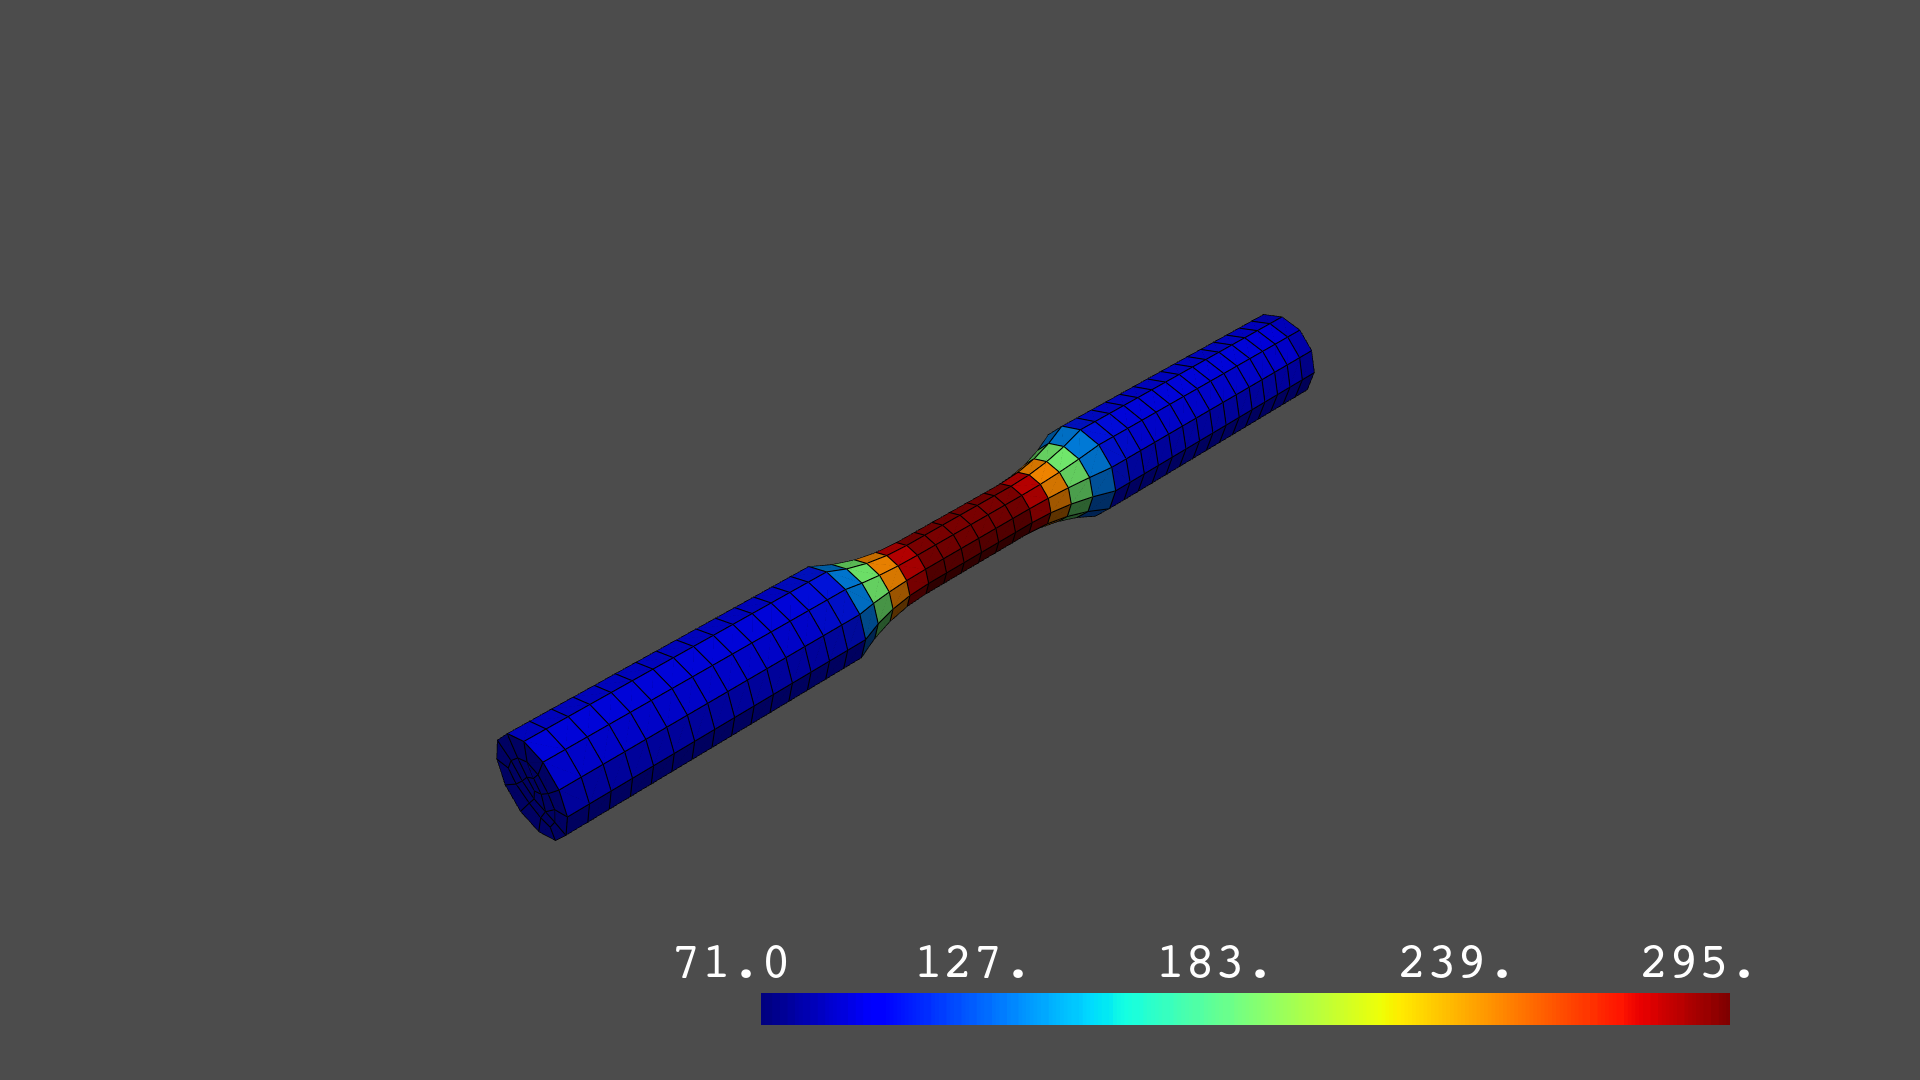

In [12]:
grid = pv.UnstructuredGrid(*surface_mesh.mesh.vtk_data())
plotter = pv.Plotter(window_size=[1920, 1080])
plotter.add_mesh(grid, scalars=surface_mesh.groupby('element_id')['mises'].mean().to_numpy(),
                show_edges=True, cmap='jet')
plotter.add_scalar_bar()
plotter.show()

## Select nodes with highest stress
We can also filter the finite element mesh by the Mises stress, only considering nodes with a stress above a certain threshold.

In [13]:
# The threshold is specified in relation to the maximum stress, by the following factor:
stress_factor = 0.8

# select elements where at least one node has at least the given mises stress
pylife_mesh_temp = pylife_mesh.copy()
maximum_stress = pylife_mesh_temp["mises"].max()
selected_node_ids = pylife_mesh_temp[pylife_mesh_temp["mises"] > stress_factor*maximum_stress].index.get_level_values("node_id")
selected_element_ids = pylife_mesh_temp[pylife_mesh_temp.index.get_level_values("node_id").isin(selected_node_ids)].index.get_level_values("element_id").unique()
selected_mesh = pylife_mesh[pylife_mesh.index.get_level_values("element_id").isin(selected_element_ids)]

# output statistic
n_elements_original = pylife_mesh.index.get_level_values("element_id").nunique()
print(f"select {len(selected_element_ids)} elements of {n_elements_original} "
      f"(= {100*len(selected_element_ids)/n_elements_original:.1f} %)")

select 250 elements of 1100 (= 22.7 %)


C:\Users\mbe7rng\AppData\Local\Temp\ipykernel_15156\3259350176.py:1: UserWarning: VTK 9 no longer accepts an offset array
  grid = pv.UnstructuredGrid(*selected_mesh.mesh.vtk_data())
C:\Users\mbe7rng\AppData\Roaming\Python\Python39\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


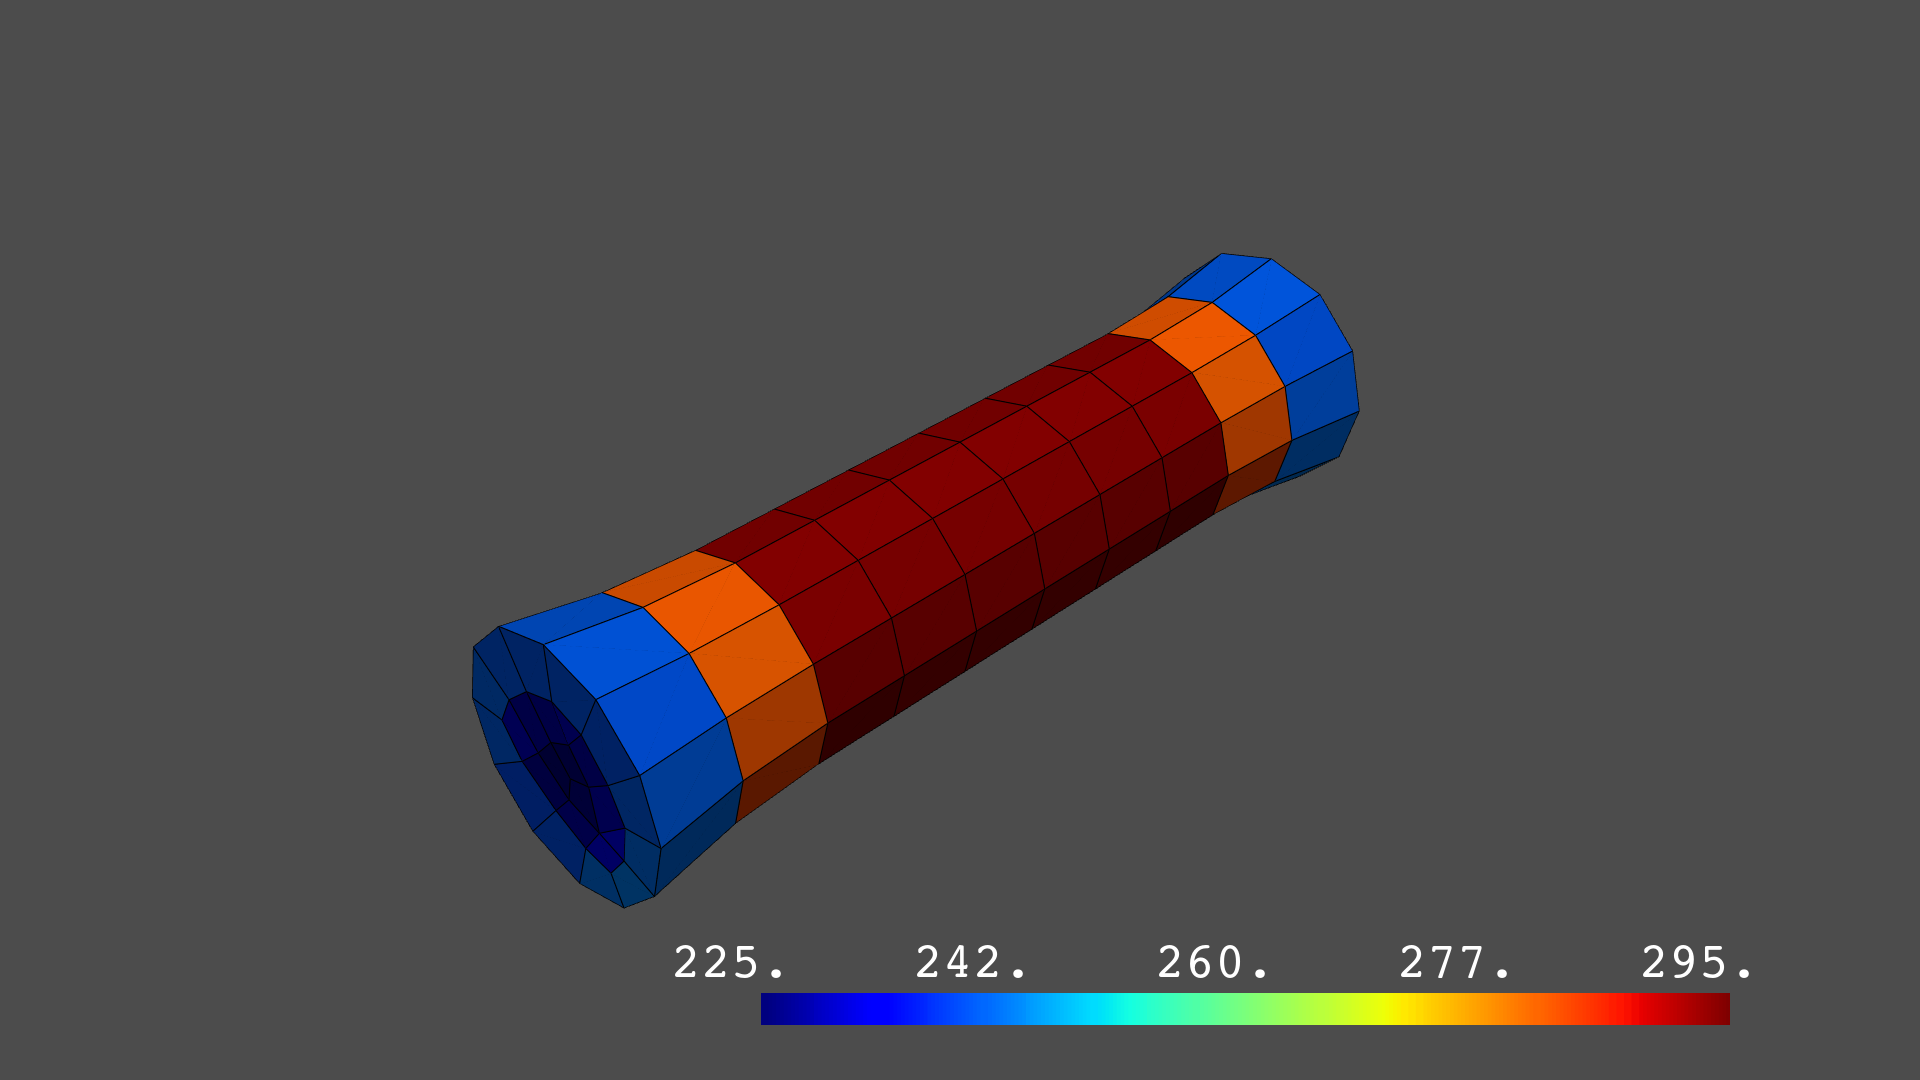

In [14]:
grid = pv.UnstructuredGrid(*selected_mesh.mesh.vtk_data())
plotter = pv.Plotter(window_size=[1920, 1080])
plotter.add_mesh(grid, scalars=selected_mesh.groupby('element_id')['mises'].mean().to_numpy(),
                show_edges=True, cmap='jet')
plotter.add_scalar_bar()
plotter.show()